# VEHICLE DETECTION

In [1]:
%pylab inline
import os
import cv2
import pickle
import numpy as np
import random
from scipy.misc import imresize

Populating the interactive namespace from numpy and matplotlib


In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Helper methods

In [3]:
pylab.rcParams['figure.figsize'] = (14, 12)

def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def reduce(img):
    return np.reshape(img, img.shape[:2])

def plot_images(images, row=1, im_prep=None, titles=None, cmap=None, figsize=(12, 12)):
    add_col = 1 if (len(images) % row) else 0
    col = (len(images) // row) + add_col
    fig, axes = subplots(row,col, subplot_kw={'xticks': [], 'yticks': []}, figsize=figsize)
    fig.subplots_adjust(hspace=0.3, wspace=0.05)
    if im_prep is None:
        im_prep = lambda x: x

    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        img = im_prep(images[i])
        if (len(img.shape) < 3) and cmap is None:
            cmap='gray'
        ax.imshow(img, cmap=cmap)
        if titles is not None:
            ax.set_title(titles[i])
    show()
    
def make_vid(out, pipeline, src="../Advanced-Lane-Lines/project_video.mp4"):
    white_output = out
    clip1 = VideoFileClip(src)
    white_clip = clip1.fl_image(pipeline)
    white_clip.write_videofile(white_output, audio=False)
    return clip1

In [4]:
test_data_path = './test_images/'

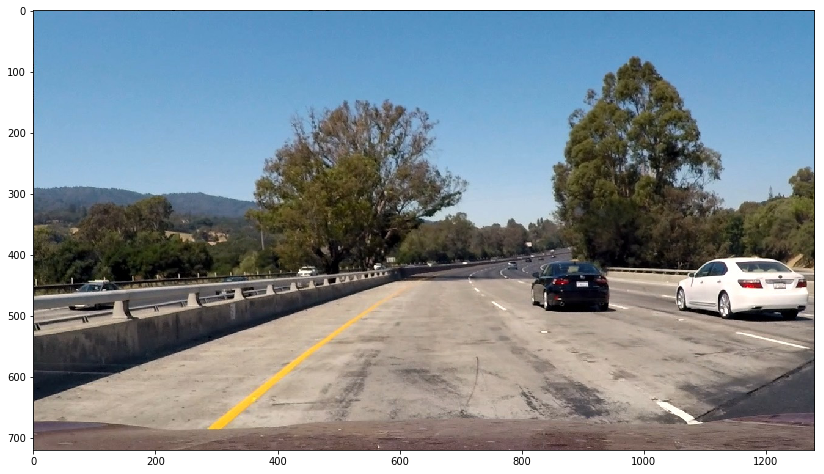

In [5]:
img = cv2.imread(test_data_path + 'test1.jpg')
imshow(bgr2rgb(img))

In [6]:
from skimage.feature import hog

## Car classifier

### Observe dataset

In [7]:
imgs = [imread('data/vehicles/GTI_Far/image0000.png'), 
        imread('data/vehicles/GTI_Left/image0009.png'),
        imread('data/vehicles/KITTI_extracted/1.png'),
        imread('data/non-vehicles/Extras/extra1.png'),
        imread('data/non-vehicles/GTI/image1.png'),
        imread('data/non-vehicles/GTI/image20.png')]

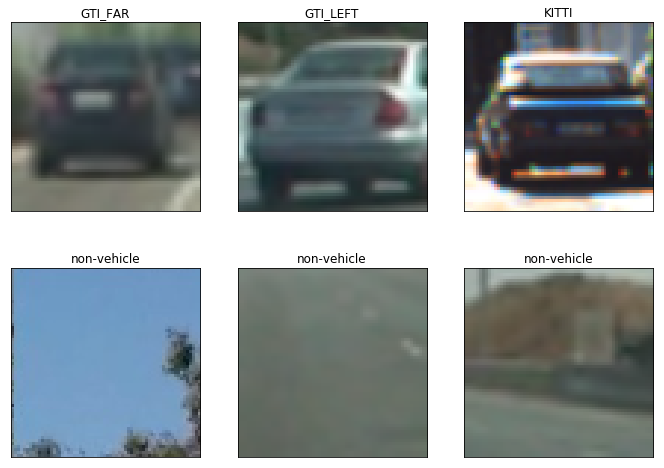

In [8]:
plot_images(imgs, row=2, titles=('GTI_FAR', 'GTI_LEFT', 'KITTI', *(['non-vehicle']*3)), figsize=(12,8))

### Image preprocessing

In [9]:
import image_preproc as imp

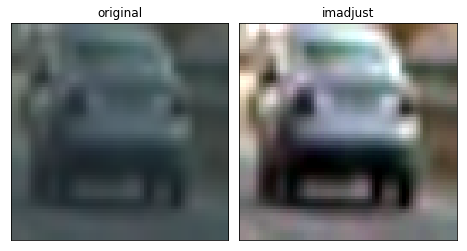

In [10]:
img = cv2.imread('data/vehicles/GTI_Far/image0030.png')
# Matlab's imadjust method
# https://stackoverflow.com/a/44611551/4875690
pimg = imp.imadjust(img)

plot_images((img, pimg), im_prep=bgr2rgb, figsize=(8,8), titles=('original', 'imadjust'))

A square root of the image normalizes it and gets uniform brightness thus reducing the effect of shadows

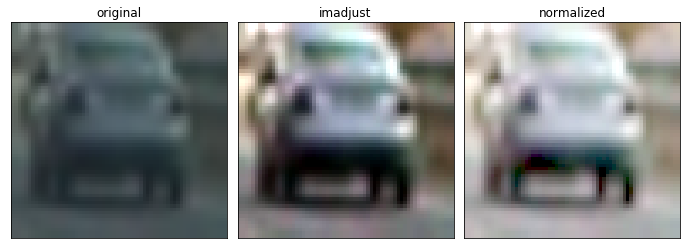

In [11]:
img_norm = (np.sqrt(pimg.astype(np.float32)/255)*255).astype(np.uint8)

plot_images((img, pimg, img_norm), im_prep=bgr2rgb, 
            titles=('original', 'imadjust', 'normalized'))

### Extracting features

In [12]:
def split_layers(image):
    return [np.reshape(x, x.shape[:2]) for x in np.array_split(image, 3, 2)]

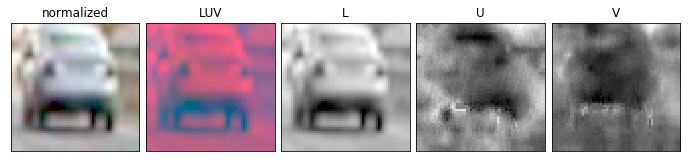

In [13]:
LUV = cv2.cvtColor(img_norm, cv2.COLOR_BGR2LUV)
LUVs = split_layers(LUV)
plot_images((bgr2rgb(img_norm), LUV, *LUVs),
           titles=('normalized', 'LUV', 'L', 'U','V'))

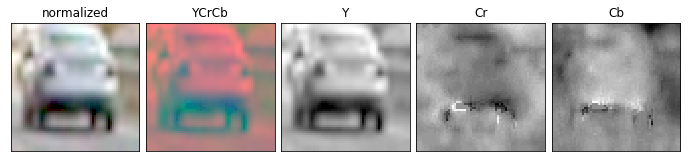

In [14]:
YCB = cv2.cvtColor(img_norm, cv2.COLOR_BGR2YCrCb)
YCBs = split_layers(YCB)
plot_images((bgr2rgb(img_norm), YCB, *YCBs),
           titles=('normalized', 'YCrCb', 'Y', 'Cr','Cb'))

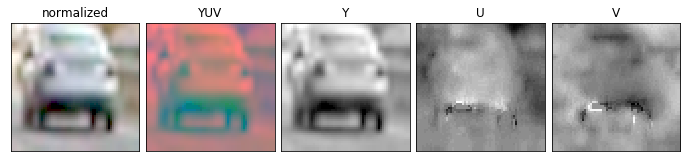

In [15]:
YUV = cv2.cvtColor(img_norm, cv2.COLOR_BGR2YUV)
YUVs = split_layers(YUV)
plot_images((bgr2rgb(img_norm), YUV, *YUVs),
           titles=('normalized', 'YUV', *'YUV'))

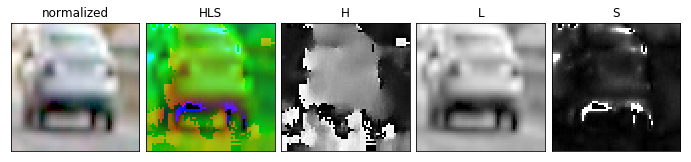

In [16]:
HLS = cv2.cvtColor(img_norm, cv2.COLOR_BGR2HLS)
HLSs = split_layers(HLS)
plot_images((bgr2rgb(img_norm), HLS, *HLSs),
           titles=('normalized', 'HLS', 'H', 'L','S'))

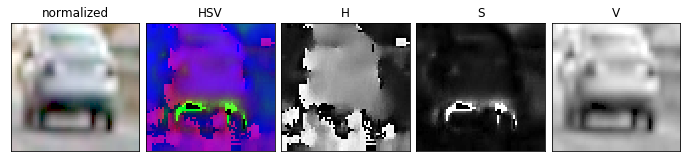

In [17]:
HSV = cv2.cvtColor(img_norm, cv2.COLOR_BGR2HSV)
HSVs = split_layers(HSV)
plot_images((bgr2rgb(img_norm), HSV, *HSVs),
           titles=('normalized', 'HSV', 'H', 'S','V'))

In [ ]:
img_normb = bgr2rgb(img_norm)
plot_images((img_normb, LUV, L,U,V, 
             img_normb, YUV, *YUVs,
             img_normb, HLS, H,L,S,
             img_normb, HSV, H,S,V),
           titles=('normalized', 'LUV', 'L', 'U','V',
                   'normalized', 'YUV', *'YUV',
                  'normalized', 'HLS', 'H', 'L', 'S',
                  'normalized', 'HSV', 'H', 'S','V'), row=4)

#### The only valuable channel I can see from this color sets is L(LUV), L(HLS) and V(HSV)
The rest is totally distructing

In [18]:
histograms = [np.histogram(HLS[:,:,x], bins=32, range=(0,256)) for x in range(HLS.shape[2])]
titles = ['histogram H', 'L', 'S']

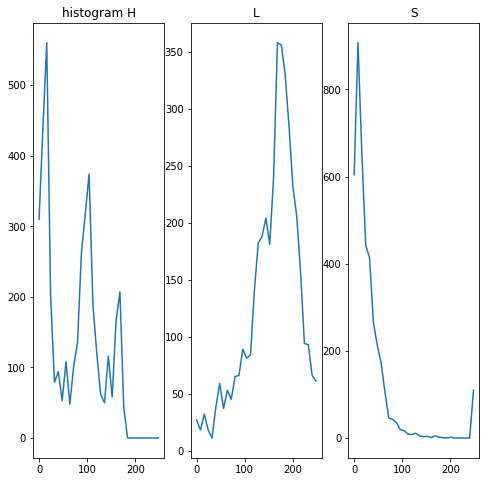

In [19]:
fig, axes = subplots(1,3, figsize=(8,8))
#fig.subplots_adjust(hspace=0.3, wspace=0.05)

for i, ax in enumerate(axes.flat):
    ax.plot(histograms[i][1][:-1], histograms[i][0])
    ax.set_title(titles[i])
show()

In [21]:
def get_hog_imgs(img, orientations=10, pixels_per_cell=8, cells_per_block=1):
    return [hog(X, orientations=orientations, 
                pixels_per_cell=(pixels_per_cell, pixels_per_cell), 
                visualise=True,
                cells_per_block=(cells_per_block, cells_per_block), 
                transform_sqrt=False, block_norm='L2')[1] for X in split_layers(img)]

#### HOG on LUV color space

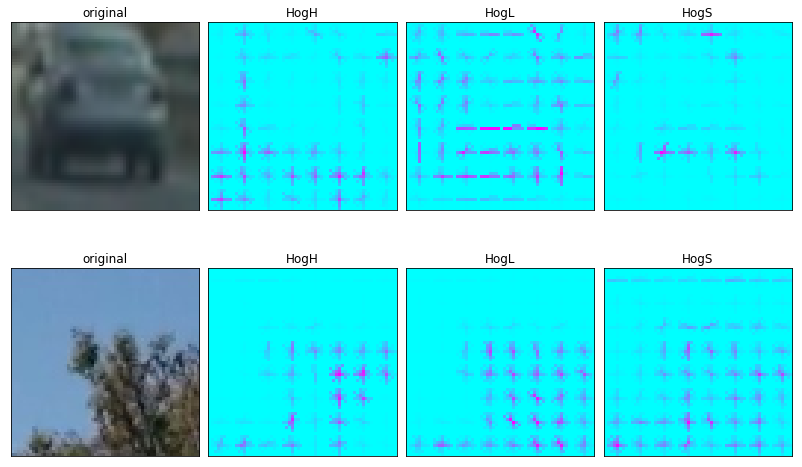

In [24]:
nv_img = cv2.imread('data/non-vehicles/Extras/extra14.png')
def prepare_img_HLS(image):
    pimg = imp.imadjust(image)
    img_norm = (np.sqrt(pimg.astype(np.float32)/255)*255).astype(np.uint8)
    HLS = cv2.cvtColor(img_norm, cv2.COLOR_BGR2HLS)
    return HLS
nv_HLS = prepare_img_HLS(nv_img)
plot_images((bgr2rgb(img), *get_hog_imgs(HLS), 
             bgr2rgb(nv_img), *get_hog_imgs(nv_HLS)), cmap='cool', row=2, figsize=(14,8),
           titles=('original', 'HogH','HogL','HogS')*2)

### Extracting features

In [25]:
im_size = (64,64)
PIX_PER_CELL = 8
CELLS_PER_BLOCK = 1

def get_hog_features(img, orientations=12, pixels_per_cell=PIX_PER_CELL, cells_per_block=CELLS_PER_BLOCK):
    return [hog(img[:,:,x], orientations=orientations, 
                pixels_per_cell=(pixels_per_cell, pixels_per_cell), 
                visualise=False, feature_vector=False,
                cells_per_block=(cells_per_block, cells_per_block), 
                transform_sqrt=False, block_norm='L1') for x in range(img.shape[2])]

def prep_adjnorm_ycb(image, cvColor=cv2.COLOR_BGR2YCrCb):
    img_adj = image
    img_norm = (np.sqrt(img_adj.astype(np.float32)/255)*255).astype(np.uint8)
    YCB = cv2.cvtColor(img_norm, cv2.COLOR_BGR2YCrCb)
    return YCB

def get_features(image, size=None, bins=32, hrange=(0,256), preprocess=None, hogs=None):
    if size:
        image = cv2.resize(image, size)
    img_prep = image
    if preprocess:
        img_prep = preprocess(image)
    img_tiny = (cv2.resize(img_prep, (16,16)))
    hists = [np.histogram(img_prep[:,:,x], bins=bins, range=hrange)[0] for x in range(img_prep.shape[2])]
    if hogs is None:
        hogs = get_hog_features(img_prep)
    return np.hstack((img_tiny.ravel(),*hists, *[h.ravel() for h in hogs]))

In [26]:
prep_adjnorm = prep_adjnorm_ycb

In [28]:
%time features = get_features(img, (64,64), preprocess=prep_adjnorm)
print(features.shape)

Wall time: 5.01 ms
(3168,)


In [30]:
h=get_hog_features((cv2.resize(img, (64,64))), 12, 8, 1)

h[0].shape

(8, 8, 1, 1, 12)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC

from sklearn.model_selection import train_test_split

## Training classifier

#### Loading training data set

In [32]:
data_dir = 'data'
vehicles = []
non_vehicles = []
for root, subdirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('png'):
            image = cv2.imread(os.path.join(root, file))
            if 'non-vehicle' in root:
                non_vehicles.append(image)
            else:
                vehicles.append(image)
print('cars: {}, non-cars: {}'.format(len(vehicles), len(non_vehicles)))

cars: 8792, non-cars: 8968


#### Extracting features for training

In [33]:
features = []
for img in (vehicles+non_vehicles):
    features.append(get_features(img, (64,64), preprocess=prep_adjnorm))

In [34]:
X = np.array(features, dtype=np.float32)
Y = np.hstack((np.ones(len(vehicles)), np.zeros(len(non_vehicles))))
print(X.shape)
print(Y.shape)

(17760, 3168)
(17760,)


#### Scale the data

In [35]:
scaler = StandardScaler().fit(X)
scaled_X = scaler.transform(X)

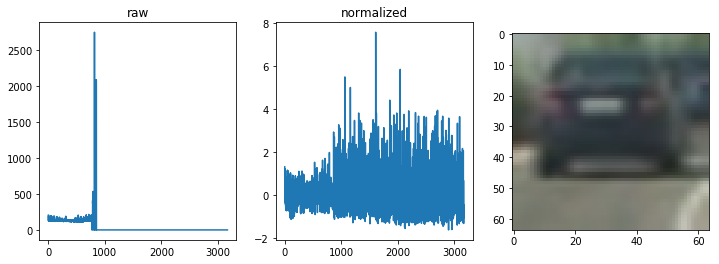

In [36]:
fig, axes = subplots(1,3, figsize=(12,4))
#fig.subplots_adjust(hspace=0.3, wspace=0.05)

ax1, ax2, ax3 = axes.flat
ax1.plot(X[0])
ax1.set_title('raw')
ax2.plot(scaled_X[0])
ax2.set_title('normalized')
ax3.imshow(bgr2rgb(vehicles[1]))
show()

#### Split the dataset into training and testing sets

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, Y, 
    test_size=0.10, 
    random_state=random.seed())

In [63]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(15984, 3168) (1776, 3168)
(15984,) (1776,)


#### Training LinearSVC

In [64]:
cls = LinearSVC()
%time cls.fit(X_train, y_train)
result = cls.predict(X_test)

Wall time: 9.13 s


In [65]:
true = y_test == 1
test_len = len(y_test)
positive = result == 1
true_positive = np.sum(true & positive)
true_negative = np.sum(true & np.logical_not(positive))
false_negative = np.sum(np.logical_not(true) & np.logical_not(positive))
false_positive = np.sum(np.logical_not(true) & positive)
print("TP {0:5.2f}, TN {1:5.2f}\nFN {2:5.2f}, FP {3:5.2f}".format(
    float(true_positive)/test_len, 
    float(true_negative)/test_len,                                        
    float(false_negative)/test_len, 
    float(false_positive)/test_len))
%time score = cls.score(X_test, y_test)
print('score:', score)

TP  0.48, TN  0.00
FN  0.52, FP  0.00
Wall time: 30.1 ms
score: 0.994932432432


##### visualizing false-positives for non-vehicles

In [66]:
fpnv = []
nvresult = cls.predict(scaled_X[len(vehicles):])
    

Inon_vehicles = np.array(non_vehicles)

fpnv = Inon_vehicles[nvresult==1]

false_pos = [fpnv[i] for i in range(fpnv.shape[0])]

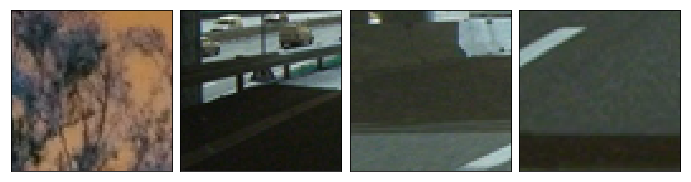

In [70]:
plot_images(false_pos, row=1)

In [71]:
data = {'scaler': scaler,
        'classifier': cls}

pickle.dump(data, open('classifier.p', 'wb'))

## Finding cars on image

In [ ]:
with open('classifier.p', 'rb') as f:
    data = pickle.load(f)

In [ ]:
cls=data['classifier']
scaler=data['scaler']

In [72]:
img = cv2.imread(test_data_path + 'test1.jpg')
# img = cv2.imread('images/test1.jpg')
# img = cv2.imread('output/v001.png')

#### Crop picture to reduce the area of  vehicle search

In [73]:
def get_pic_area(image, search_area=[350, 650, 0, img.shape[1]]):
    return image[search_area[0]:search_area[1], 
                 search_area[2]:search_area[3]]
cropped = get_pic_area(img)

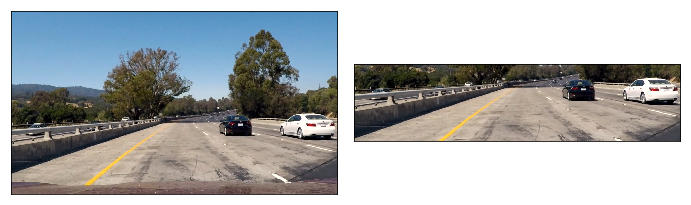

In [74]:
plot_images((img, cropped), im_prep=bgr2rgb)

### Sliding window

### Trying to slide window over set of rescaled images

In [82]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    h = windowSize[1]
    w = windowSize[0]
    for y in range(0, image.shape[0], stepSize):
        if y+h > image.shape[0]:
            break
        for x in range(0, image.shape[1], stepSize):
            if x+w > image.shape[1]:
                continue
            cimg = image[y:y+h, x:x+w]
            yield (cimg, (x,y), (x+w,y+h))

In [81]:
def get_points(img, simg, pt1, pt2):
    """
    finds the scale of simg agains img
    returns (pt1, pt2) * scale
    """
    ky = img.shape[0]/simg.shape[0]
    kx = img.shape[1]/simg.shape[1]
    k = np.array([kx, ky])
    rt1 = (np.array(pt1)*k).astype(np.uint).tolist()
    rt2 = (np.array(pt2)*k).astype(np.uint).tolist()
    return (tuple(rt1), tuple(rt2))

In [83]:
def get_all_features(cropped):
    ws_features = []
    ws = []
#     prep_image = prep_adjnorm_hls(cropped)
    prep_image = cropped
    wimgs = []
    win = 64
    h,w,_ = cropped.shape
    koef = 1.35
    for i in range(1,8):
        rimg = cv2.resize(cropped, (int(w/(i*koef)), int(h/(i*koef))))
        kx = ky = koef * (i)
        for wimg, (x,y),(x2,y2) in sliding_window(rimg, win//5, (win,win)):
            pt1 = (int(x*kx), int(y*ky))
            pt2 = (int(x2*kx), int(y2*ky))
            ws.append((pt1,pt2))
            features = get_features(wimg, preprocess=prep_adjnorm)
            ws_features.append(features)
    return ws, ws_features
%time ws,ws_features = get_all_features(cropped)
print(len(ws))

Wall time: 5.42 s
1198


In [84]:
scaled_X = scaler.transform(np.array(ws_features, dtype=np.float32))

result = cls.predict(scaled_X)

wsa = np.array(ws)

cars = wsa[result==1]
print(cars.shape)

(30, 2, 2)


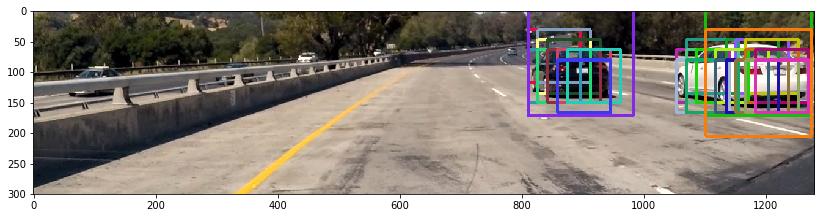

In [85]:
img = cropped
pl = img.copy()
for box in cars:
    pt1, pt2 = tuple(map(tuple, box))
    cv2.rectangle(pl, pt1, pt2, [random.randint(0,255) for _ in range(3)], 3)
imshow(bgr2rgb(pl))

great! But very slow, more than 4 sec per one frame... 

#### Sliding window on HOG

In [76]:
def sliding_hog_window(hogs, hstep=1, pix_per_cell=PIX_PER_CELL, cell_per_window=8):
    h = w = cell_per_window
    ppc = pix_per_cell
    hshape = hogs[0].shape
    for y in range(0, hshape[0], hstep):
        if (h+y) > hshape[0]:
            break
        for x in range(0, hshape[1], hstep):
            if (w+x) > hshape[1]:
                continue
            win_hogs = [hog[y:y+h,x:x+h] for hog in hogs]
            pt1 = (x*ppc, y*ppc)
            pt2 = ((x+w)*ppc, (y+h)*ppc)
            yield (win_hogs, pt1, pt2)

##### visualization of windows

In [77]:
pl = img.copy()
print(pl.shape, img.shape)
i = 0
hogs = get_hog_features((pl))
for whogs,pt1,pt2 in sliding_hog_window(hogs, 8):
    cv2.rectangle(pl, pt1, pt2, [random.randint(0,255) for _ in range(3)], 3)
    i+=1
    
print(i)

(720, 1280, 3) (720, 1280, 3)
220


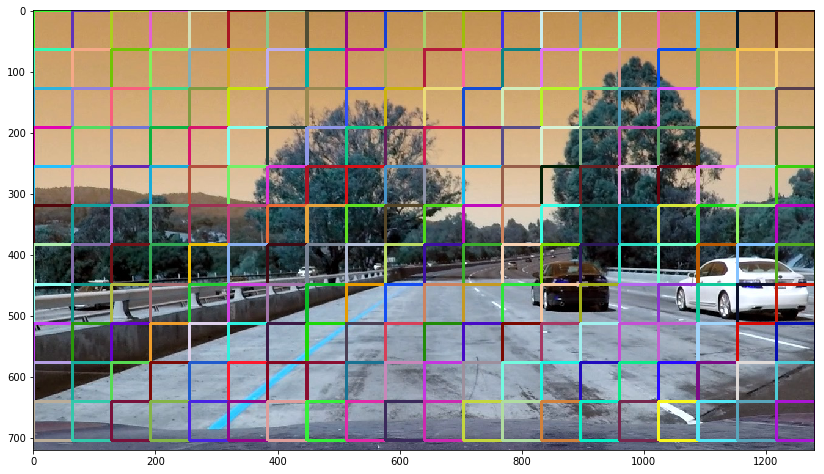

In [79]:
imshow(pl)

#### calculating HOG per whole picture, not per single window

Wall time: 1.7 s
all boxes:  2596
found boxes:  55


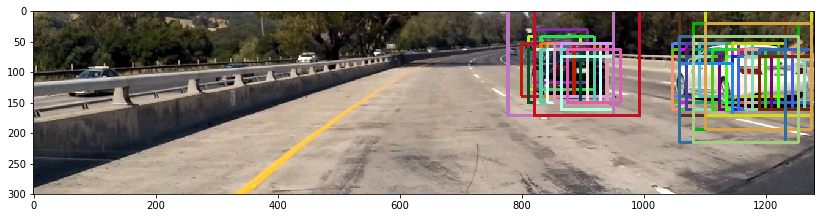

In [86]:
def get_all_features(cropped, cvColor=cv2.COLOR_BGR2YCrCb):
    ws_features = []
    ws = []
    prep_image = prep_adjnorm(cropped, cvColor=cvColor)
    h,w,_ = cropped.shape
    koef = 1.35
    for i in range(1,8):
        rimg = cv2.resize(prep_image, (int(w/(i*koef)), int(h/(i*koef))))
        hogs = get_hog_features(rimg)
        kx = ky = i*koef
        for whogs, (x,y),(x2,y2) in sliding_hog_window(hogs, 1):
            pt1 = (int(x*kx), int(y*ky))
            pt2 = (int(x2*kx), int(y2*ky))
            ws.append((pt1,pt2))
            wimg = rimg[y:y2,x:x2]
            hists = [np.histogram(wimg[:,:,i], bins=32, range=(0,256))[0] for i in range(wimg.shape[2])]
            img_tiny = cv2.resize(wimg, (16,16))
            features = np.hstack((img_tiny.ravel(), *hists, *[h.ravel() for h in whogs]))
            ws_features.append(features.astype(np.float32))
    return ws, ws_features

%time ws,ws_features = get_all_features(cropped)
print('all boxes: ', len(ws))
scaled_X = scaler.transform(np.array(ws_features))
result = cls.predict(scaled_X)
wsa = np.array(ws)
cars = wsa[result==1]
print('found boxes: ', cars.shape[0])
img = cropped
pl = img.copy()
for box in cars:
    pt1, pt2 = tuple(map(tuple, box))
    cv2.rectangle(pl, pt1, pt2, [random.randint(0,255) for _ in range(3)], 3)
imshow(bgr2rgb(pl))

In [87]:
heatmap = np.zeros(cropped.shape[:2], dtype=np.ubyte)

In [88]:
cars.shape

(55, 2, 2)

In [89]:
for box in cars:
    pt1, pt2 = (box[0], box[1])
    heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] += 1

23


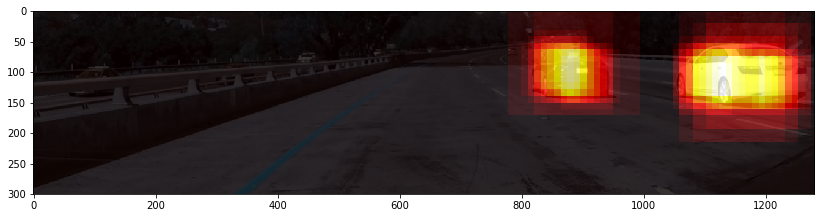

In [90]:
imshow(cropped)
imshow(heatmap, alpha=50, cmap='hot')
print(np.max(heatmap))

In [94]:
from scipy.ndimage.measurements import label
labels = label(heatmap)

### Boundary boxes

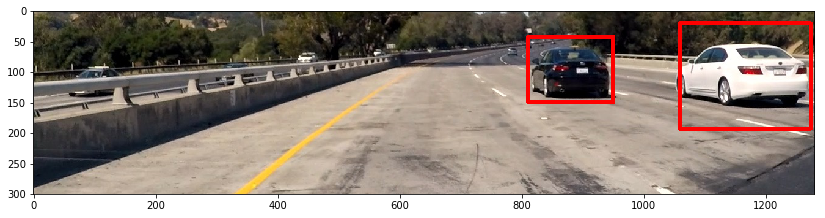

In [95]:
def draw_labeled_bboxes(img, labels, offset=350):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)+offset), (np.max(nonzerox), np.max(nonzeroy)+offset))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
bimg = draw_labeled_bboxes(img.copy(), labels, offset=0)
imshow(bgr2rgb(bimg))

In [96]:
def pipeline_SVC(image, ret_heatmap=False, cvColor=cv2.COLOR_BGR2YCrCb):
    cropped = get_pic_area(image)
    ws, ws_features = get_all_features(cropped, cvColor=cvColor)
    scaled_X = scaler.transform(ws_features)
    result = cls.predict(scaled_X)
    wsa = np.array(ws)
    cars = wsa[result==1]
    heatmap = np.zeros(cropped.shape[:2], dtype=np.ubyte)
    for box in cars:
        pt1, pt2 = (box[0], box[1])
        heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] += 1
    if ret_heatmap:
        return heatmap
    heatmap[heatmap<10] = 0
    labels = label(heatmap)
    bimg = draw_labeled_bboxes(image.copy(), labels)
    return bimg

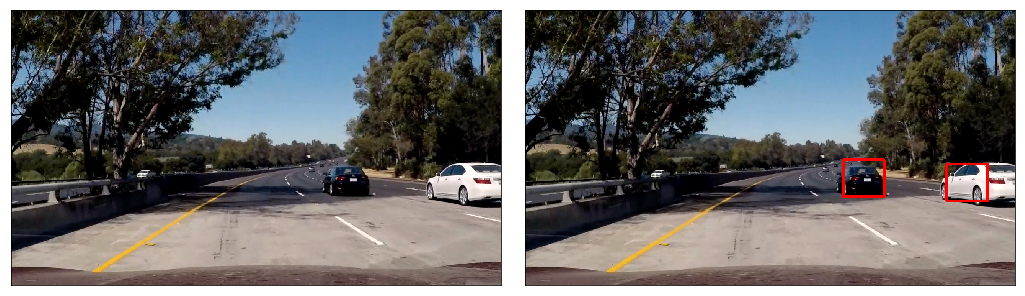

Wall time: 2.21 s


In [97]:
img = cv2.imread('./test_images/test5.jpg')

%time plot_images((img, pipeline_SVC(img)), figsize=(18,16), im_prep=bgr2rgb)

In [99]:
from collections import deque

## SVC pipeline

In [100]:
hms = deque(maxlen=10)
def pipeline_SVC(image, cvColor=cv2.COLOR_BGR2YCrCb):
    # crop the road
    cropped = get_pic_area(image)
    # get all features (spatial, histogram, HOG)
    ws, ws_features = get_all_features(cropped, cvColor=cvColor)
    scaled_X = scaler.transform(ws_features)
    result = cls.predict(scaled_X)
    wsa = np.array(ws)
    cars = wsa[result==1]
    heatmap = np.zeros(cropped.shape[:2], dtype=np.ubyte)
    for box in cars:
        pt1, pt2 = (box[0], box[1])
        heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] += 1
    heatmap[heatmap<4] = 0
    hms.append(heatmap)
    stream_heatmap = np.zeros_like(heatmap)
    for h in hms:
        stream_heatmap[h>2] += 1
    stream_heatmap[stream_heatmap<6]=0 
    labels = label(stream_heatmap)
    bimg = draw_labeled_bboxes(image.copy(), labels)
    return bimg

In [101]:
%time clip = make_vid('svc.mp4', pipeline=lambda x: pipeline_SVC(x, cvColor=cv2.COLOR_RGB2YCrCb))

[MoviePy] >>>> Building video svc.mp4
[MoviePy] Writing video svc.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [38:24<00:01,  1.81s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: svc.mp4 

Wall time: 38min 27s


## NN classification

In [102]:
import keras

Using TensorFlow backend.


In [103]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, Lambda, Input
from keras.optimizers import SGD
from keras.layers.advanced_activations import ELU
from keras.callbacks import LearningRateScheduler, EarlyStopping

In [108]:
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras import initializers

In [131]:
model = keras.models.Sequential()
winit = initializers.TruncatedNormal(stddev=0.05)
model.add(Lambda(lambda x: x/127.5 - 1, input_shape=(64,64,3)))
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(48, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(256, activation='elu'))
model.add(Dense(2, activation='softmax'))

In [133]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [109]:
X = np.array(vehicles+non_vehicles)
Y = to_categorical(np.hstack((np.ones(len(vehicles)), np.zeros(len(non_vehicles)))))
#Xt = Xt / np.max(Xt)

In [132]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 48)        13872     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 8, 8, 48)          0         
__________

In [134]:
model.fit(X, Y, 
         validation_split=0.1, shuffle=True, 
         epochs=20, batch_size=128,
         verbose=2)

Train on 15984 samples, validate on 1776 samples
Epoch 1/20
11s - loss: 0.2413 - acc: 0.8860 - val_loss: 0.1664 - val_acc: 0.9544
Epoch 2/20
9s - loss: 0.0556 - acc: 0.9804 - val_loss: 0.1363 - val_acc: 0.9589
Epoch 3/20
9s - loss: 0.0309 - acc: 0.9897 - val_loss: 0.1131 - val_acc: 0.9752
Epoch 4/20
9s - loss: 0.0245 - acc: 0.9912 - val_loss: 0.1625 - val_acc: 0.9544
Epoch 5/20
9s - loss: 0.0175 - acc: 0.9940 - val_loss: 0.0856 - val_acc: 0.9854
Epoch 6/20
9s - loss: 0.0158 - acc: 0.9940 - val_loss: 0.1314 - val_acc: 0.9589
Epoch 7/20
9s - loss: 0.0236 - acc: 0.9921 - val_loss: 0.2277 - val_acc: 0.9409
Epoch 8/20
9s - loss: 0.0122 - acc: 0.9956 - val_loss: 0.1099 - val_acc: 0.9747
Epoch 9/20
9s - loss: 0.0098 - acc: 0.9971 - val_loss: 0.1657 - val_acc: 0.9572
Epoch 10/20
9s - loss: 0.0063 - acc: 0.9982 - val_loss: 0.1161 - val_acc: 0.9758
Epoch 11/20
9s - loss: 0.0112 - acc: 0.9965 - val_loss: 0.2451 - val_acc: 0.9454
Epoch 12/20
9s - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0665 - val

Ok, val_loss is quite high, but let's see how it works..

In [361]:
model.save('model.hdf5')

In [365]:
model = keras.models.load_model('model.hdf5')

In [267]:
def sliding_window(image, stepSize, windowSize, padding=False):
    # slide a window across the image
    h = windowSize[1]
    w = windowSize[0]
    for y in range(0, image.shape[0], stepSize):
        if y+h > image.shape[0]:
            break
        for x in range(0, image.shape[1], stepSize):
            if x+w > image.shape[1] and not padding:
                continue
            cimg = image[y:y+h, x:x+w]
            if padding:
                hn,wn = cimg.shape[:2]
                if (hn < h):
                    cimg = np.vstack((cimg, np.ones((h-hn, wn, 3), dtype=np.ubyte)))
                if (wn < w):
                    cimg = np.hstack((cimg, np.ones((h, w-wn, 3), dtype=np.ubyte)))
            yield (cimg, (x,y), (x+w,y+h))

In [366]:
h,w,_ = cropped.shape
koef = 1.2
ws=[]
wimgs=[]
win=64
for i in range(1,6):
    rimg = cv2.resize(cropped, (int(w/(i*koef)), int(h/(i*koef))))
    kx = ky = koef * (i)
    for wimg, (x,y),(x2,y2) in sliding_window(rimg, win//4, (win,win), padding=True):
        pt1 = (int(x*kx), int(y*ky))
        pt2 = (int(x2*kx), int(y2*ky))
        ws.append((pt1,pt2))
        wimgs.append(wimg)
print(len(ws))
result = model.predict(np.array(wimgs))

986


In [367]:
res = np.argmax(result, axis=1)

In [368]:
cars = np.array(ws)[res==1]

In [369]:
cars.shape

(146, 2, 2)

In [370]:
heatmap = np.zeros(cropped.shape[:2], dtype=np.ubyte)
for box in np.array(ws)[res==1]:
    pt1, pt2 = (box[0], box[1])
    heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] += 1

# for box in np.array(ws)[res==0]:
#     pt1, pt2 = (box[0], box[1])
#     heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] = 0
print(np.max(heatmap))

36


In [257]:
heatmap[heatmap<15] = 0

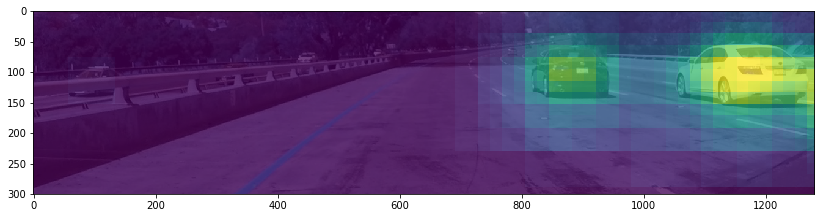

In [371]:
imshow(cropped)
imshow(heatmap, alpha=60)

### CNN pipeline

In [413]:
hms = deque(maxlen=6)
tpss = deque(maxlen=100)
t0=0
def pipeline_NN(image, draw_heatmap=True, rgb=True, show_fps=True):
    # crop the road
    cropped = get_pic_area(image)
    if rgb:
        cropped = cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR)
    # get all features (spatial, histogram, HOG)
    h,w,_ = cropped.shape
    koef = 1.2
    ws=[]
    wimgs=[]
    win=64
    for i in range(1,6):
        rimg = cv2.resize(cropped, (int(w/(i*koef)), int(h/(i*koef))))
        kx = ky = koef * (i)
        for wimg, (x,y),(x2,y2) in sliding_window(rimg, win//4, (win,win), padding=False):
            pt1 = (int(x*kx), int(y*ky))
            pt2 = (int(x2*kx), int(y2*ky))
            ws.append((pt1,pt2))
            wimgs.append(wimg)
    result = model.predict(np.array(wimgs))
    res = np.argmax(result, axis=1)
    wsa = np.array(ws)
    cars = wsa[res==1]
    non_cars = wsa[res==0]
    heatmap = np.zeros(cropped.shape[:2], dtype=np.ubyte)
    for box in cars:
        pt1, pt2 = (box[0], box[1])
        heatmap[pt1[1]:pt2[1],pt1[0]:pt2[0]] += 1
        
    heatmap[heatmap<10] = 0
    hms.append(heatmap)
    stream_heatmap = np.zeros_like(heatmap)
    for h in hms:
        stream_heatmap[h>0] += 1
    stream_heatmap[stream_heatmap<5]=0 
    labels = label(stream_heatmap)
    bimg = draw_labeled_bboxes(image.copy(), labels)
    if draw_heatmap:
        heatmap = (heatmap * (255/np.max(heatmap))).astype(np.ubyte)
        hm = np.dstack([heatmap]*3)
        r = cv2.addWeighted(hm, 1, cropped, 0.5, 0)
        if rgb:
            r = bgr2rgb(r)
        bimg = np.vstack((bimg, r))
    if show_fps:
        global t0
        tn = time()
        if t0:
            t1 = tn - t0
            tpss.append(t1)
            fps = len(tpss)/ (np.sum(tpss))
            cv2.putText(bimg, '{:.2f} fps'.format(fps), (10,30), cv2.FONT_HERSHEY_PLAIN, 2, 255)
        t0 = tn
    return bimg

In [409]:
%timeit frame=pipeline_NN(img, True)

256 ms ± 3.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


###### ~260 ms per frame (on M1000M NVIDIA GPU)

In [378]:
from time import time

In [414]:
cap = cv2.VideoCapture('../Advanced-Lane-Lines/project_video.mp4')
heatmaps = []
vimgs = []
ret = True
hms = deque(maxlen=6)
cv2.namedWindow("ww", cv2.WINDOW_NORMAL)
tpss = deque(maxlen=250)
t0 = time()
while ret:
    ret, frame = cap.read()
    if ret:
        bimg = pipeline_NN(frame, True, False)
        cv2.imshow('ww', bimg)
        key = cv2.waitKey(1) & 0xff
        if key == ord(' '):
            break
#         heatmaps.append(heatmap)
#         vimgs.append(frame)
        #ret = False
cv2.destroyAllWindows()
cap.release()

In [415]:
white_output = 'project_video_out_keras.mp4'
clip1 = VideoFileClip("../Advanced-Lane-Lines/project_video.mp4")
white_clip = clip1.fl_image(pipeline_NN)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out_keras.mp4
[MoviePy] Writing video project_video_out_keras.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:54<00:00,  3.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_keras.mp4 

Wall time: 5min 55s


In [416]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))